In [2]:
from math import sqrt

import torch
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
import pandas as pd
import pyro
import pyro.distributions as dist
import zuko
import numpy as np
from tqdm import tqdm
import IPython
from IPython.display import HTML

%matplotlib widget
sns.set(style="white", context="notebook", palette="deep", color_codes=True)

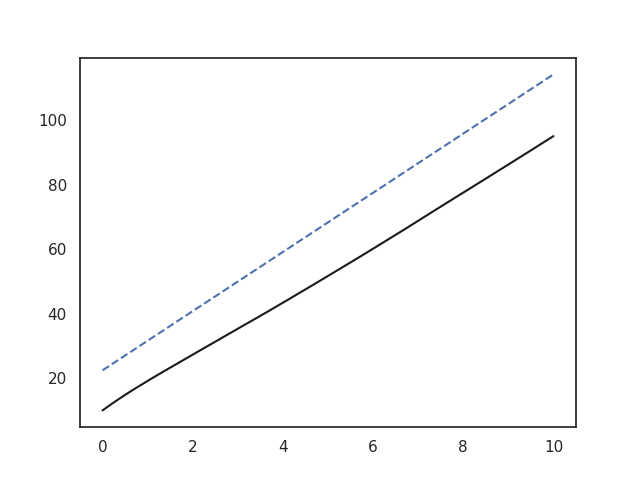

In [144]:
# Implement the AV models (thanks ChatGPT)


class IDMModel(torch.nn.Module):
    def __init__(
        self,
        max_acceleration,
        desired_velocity,
        min_spacing,
        time_headway,
        delta,
    ):
        super(IDMModel, self).__init__()
        self.max_acceleration = max_acceleration
        self.desired_velocity = desired_velocity
        self.min_spacing = min_spacing
        self.time_headway = time_headway
        self.delta = delta

    def forward(self, velocity, lead_velocity, spacing):
        # Desired gap
        desired_gap = (
            self.min_spacing
            + velocity * self.time_headway
            + (velocity * (velocity - lead_velocity))
            / (2 * sqrt(self.max_acceleration * self.max_acceleration))
        )
        # Acceleration
        acceleration = self.max_acceleration * (
            1
            - torch.pow((velocity / self.desired_velocity), self.delta)
            - (desired_gap / spacing) ** 2
        )
        acceleration = torch.clamp(
            acceleration, min=-self.max_acceleration, max=self.max_acceleration
        )
        return acceleration


def model(T=100, dt=0.1):
    """Simulate a car using the IDM."""
    # Scene parameters
    lane_width = 3.7  # meters
    speed_limit = 10.0  # meters per second
    car_length = 4.0  # meters

    # Convenience for state indicies
    PX, PY, VX, VY = 0, 1, 2, 3

    # Set the initial state of the ego vehicle
    # [p_x, p_y, v_x, v_y, desired_lane]
    ego_state = torch.tensor([10.0, 0.0, speed_limit, 0.0])

    # Set the initial states of the non-ego vehicle.
    # These start in fixed lanes, but with variable x position and velocity.
    non_ego_states = torch.tensor(
        [
            [0.0, 0.0, 0.0, 0.0],
        ]
    )
    non_ego_states[:, VX] = speed_limit * (
        1
        + pyro.sample(
            "non_ego_vx",
            dist.Normal(0.0, 0.1).expand([non_ego_states.shape[0]]),
        )
    )
    non_ego_states[:, PX] = torch.tensor([20.0]) + pyro.sample(
        "non_ego_px",
        dist.Normal(0.0, 5.0).expand([non_ego_states.shape[0]]),
    )

    # Create the IDM and MOBIL models
    idm = IDMModel(
        max_acceleration=2.0,
        desired_velocity=speed_limit,
        min_spacing=1.0,
        time_headway=1.0,
        delta=4,
    )

    # Simulate the scene
    ego_state_trace = [ego_state]
    non_ego_states_trace = [non_ego_states]
    num_steps = int(T / dt)
    crashed = torch.tensor(False)
    crashed_at_step = None

    for t in range(num_steps):
        # Get the current state of the ego vehicle
        ego_state = ego_state_trace[-1]

        # Get the current states of the non-ego vehicles
        non_ego_states = non_ego_states_trace[-1]

        # Add some observation noise
        observed_non_ego_states = non_ego_states.clone()
        observed_non_ego_states[:, PX] += 1.0 * pyro.sample(
            f"obs_non_ego_px_{t}",
            dist.Normal(0.0, 1.0).expand([non_ego_states.shape[0]]),
        )
        observed_non_ego_states[:, VX] += speed_limit * pyro.sample(
            f"obs_non_ego_vx_{t}",
            dist.Normal(0.0, 0.1).expand([non_ego_states.shape[0]]),
        )

        # Get the vehicle in front of the ego vehicle in its lane
        leading_vehicle_in_lane = None
        for non_ego_state in observed_non_ego_states:
            # It's not leading if it's behind us
            if non_ego_state[PX] < ego_state[PX]:
                continue

            # Check if it's leading in our lane (leading = closest to ego vehicle)
            if leading_vehicle_in_lane is None:
                leading_vehicle_in_lane = non_ego_state
            elif non_ego_state[PX] < leading_vehicle_in_lane[PX]:
                leading_vehicle_in_lane = non_ego_state

        # Get the acceleration of the ego vehicle using the IDM
        acceleration = idm(
            ego_state[VX],
            leading_vehicle_in_lane[VX]
            if leading_vehicle_in_lane is not None
            else ego_state[VX],
            leading_vehicle_in_lane[PX] - ego_state[PX] - car_length
            if leading_vehicle_in_lane is not None
            else 20.0,
        )

        # Update ego dynamics, using a low-level controller to track the desired lane
        # and speed
        lane_error = ego_state[PY]
        new_ego_state = torch.tensor(
            [
                ego_state[PX] + ego_state[VX] * dt,
                ego_state[PY] + ego_state[VY] * dt,
                ego_state[VX] + acceleration * dt,
                ego_state[VY] - 1.5 * lane_error * dt - 2.0 * ego_state[VY] * dt,
            ]
        )

        # Update non-ego dynamics (assume no acceleration)
        new_non_ego_states = torch.zeros_like(non_ego_states)
        new_non_ego_states[:, PX] = non_ego_states[:, PX] + non_ego_states[:, VX] * dt
        new_non_ego_states[:, PY] = non_ego_states[:, PY] + non_ego_states[:, VY] * dt
        new_non_ego_states[:, VX] = non_ego_states[:, VX]
        new_non_ego_states[:, VY] = non_ego_states[:, VY]

        # Only update if not crashed
        crashed = torch.logical_or(
            crashed,
            torch.logical_and(
                torch.abs(new_ego_state[PX] - new_non_ego_states[:, PX])
                < 0.5 * car_length,
                torch.abs(new_ego_state[PY] - new_non_ego_states[:, PY])
                < 0.5 * lane_width,
            ),
        )
        if crashed.any():
            if crashed_at_step is None:
                crashed_at_step = t

            new_ego_state = ego_state
            new_non_ego_states = non_ego_states

        # Update the scene
        ego_state_trace.append(new_ego_state)
        non_ego_states_trace.append(new_non_ego_states)

    # Return the simulation results
    return torch.stack(ego_state_trace), torch.stack(non_ego_states_trace), crashed_at_step, crashed


T = 10
dt = 0.1
ego_states, non_ego_states, _, _ = model(T, dt)
t = torch.arange(0, T + dt, dt)

plt.clf()
fig = plt.figure()
plt.plot(t, non_ego_states[:, 0, 0], "--", label="Non-ego 0")

plt.plot(t, ego_states[:, 0], "k-", label="Ego")

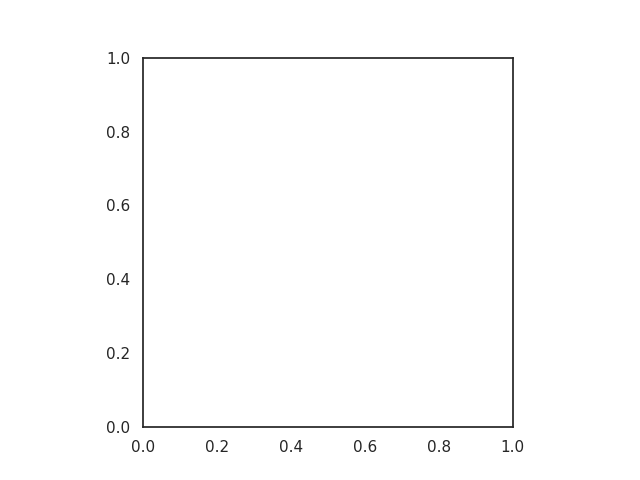

In [145]:
T, n, _ = non_ego_states.shape
fig, ax = plt.subplots()
ax.set_aspect("equal")
timestep = 0.1


def update(frame):
    ax.clear()
    ax.set_xlim(0, 150)  # Set appropriate limits for x-axis
    ax.set_ylim(-10, 10)  # Set appropriate limits for y-axis
    ax.axhline(y=0, color="k", linestyle="--")  # lane 0 centerline
    ax.axhline(y=3.7, color="k", linestyle="--")  # lane 1 centerline
    ax.set_title(f"Time: {frame * timestep:.2f} seconds")

    # Plot the ego car
    ego_x, ego_y = ego_states[frame, 0], ego_states[frame, 1]
    ax.plot(ego_x, ego_y, "ro", label="Ego Car")

    # Plot the non-ego cars
    for i in range(n):
        car_x, car_y = non_ego_states[frame, i, 0], non_ego_states[frame, i, 1]
        ax.plot(car_x, car_y, "bo", label="Non-Ego Car" if i == 0 else "")

    ax.legend()


ani = animation.FuncAnimation(
    fig, update, frames=T, interval=timestep * 1000, repeat=False
)
# HTML(ani.to_jshtml())

  9%|▊         | 86/1000 [00:04<00:49, 18.35it/s]


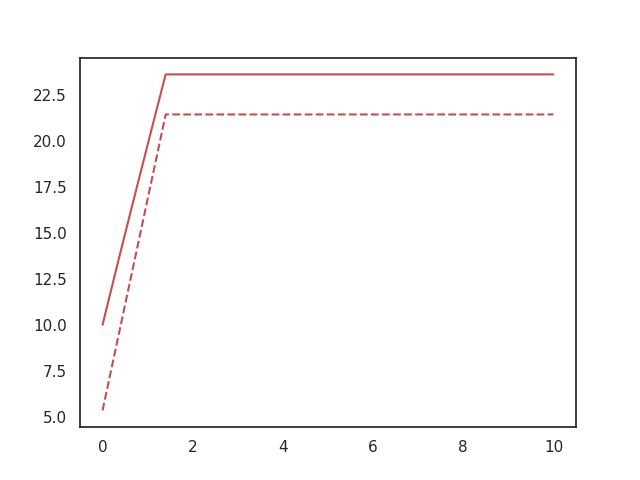

In [147]:
# Let's run a bunch of trials and try to get a failure.
max_trials = 1000
T = 10
dt = 0.1

for i in tqdm(range(max_trials)):
    trace = pyro.poutine.trace(model).get_trace(T, dt)
    crashed = trace.nodes["_RETURN"]["value"][-1]
    crashed_at_step = trace.nodes["_RETURN"]["value"][-2]
    
    if crashed.any() and crashed_at_step > 10:  # ignore crashes in the first 10 steps
        break

failure_ego_states, failure_non_ego_states = trace.nodes["_RETURN"]["value"][:2]
t = torch.arange(0, T + dt, dt)

plt.clf()
fig = plt.figure()
plt.plot(t, failure_non_ego_states[:, 0, 0], "r--", label="Non-ego 0")
plt.plot(t, failure_ego_states[:, 0], "r-", label="Ego")